In [1]:
#import all the necessary packages
import numpy as np #for numerical array data
import pandas as pd #for tabular data
from scipy.optimize import minimize
import matplotlib.pyplot as plt #for plotting purposes
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import cvxpy as cp
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from statsmodels import api as sm
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

from pandas.plotting import register_matplotlib_converters # Required
register_matplotlib_converters()

import seaborn as sns
sns.set()

In [2]:
# Dataset

file_path = '~/Desktop/python_2018/Datasets/'
life_table = pd.read_csv(file_path + 'Life_expectancy.csv')
asset_data_raw = pd.read_csv(file_path + 'AssetData.csv',index_col=0, header=0,parse_dates=[0])
SP500_data = pd.read_csv(file_path + 'SP500_CPI.csv',index_col=0, header=0,parse_dates=[0])

In [3]:
asset_data_raw.shape

(405, 17)

In [4]:
asset_data_raw.columns

Index(['World Equities', 'US Treasuries', 'High Yield ',
       'Inflation Protection', 'Currency Protection', 'Regime-5', 'Regime-7',
       'Regime-NBER', 'US Equities', 'EAFE Equities', 'EM Equities',
       'Leveraged Treasuries', 'Corp Bonds', 'TIPS(backfilled)', 'Real Estate',
       'Commodities', 'T-bill'],
      dtype='object')

In [5]:
factorname = ['World Equities','US Treasuries','High Yield ','Inflation Protection','Currency Protection']
Factors = asset_data_raw[factorname].values
assetname = ['US Equities','EAFE Equities', 'EM Equities', 'Leveraged Treasuries',
       'Corp Bonds', 'TIPS(backfilled)', 'Real Estate', 'Commodities', 'T-bill']
Assets = asset_data_raw[assetname].values
Regime = asset_data_raw['Regime-7'].values

In [6]:
factor_data = Factors[~np.isnan(Assets[:,2]),:]
asset_data = Assets[~np.isnan(Assets[:,2]),:]
regime_data = Regime[~np.isnan(Assets[:,2])]

In [7]:
np.sum(regime_data==1), np.sum(regime_data==-1)

(316, 53)

In [8]:
factor_data.mean(axis=0)

array([0.00601311, 0.00478238, 0.00692699, 0.00017678, 0.00031191])

In [9]:
# EWMA covariance?
def ewma_cov(x1, x2, smoothing_factor):
    # x1, x2 are two series    
    n = len(x1)
    weights = np.array([smoothing_factor**(n-i-1) for i in range(n)])
    return np.sum(weights*x1*x2*(1-smoothing_factor)/(1-smoothing_factor**n))

def ewma_mat(A, smoothing_factor = 0.99):
    # A: asset data (time*asset_num)
    mu = A.mean(axis=0)
    m,n = A.shape
    cov = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = ewma_cov(A[:,i]-mu[i],A[:,j]-mu[j],smoothing_factor)
    return cov
    
def cov_corr(A):
    x,y = A.shape
    if x != y:
        return A*0
    else:
        B = np.ones((x,y))
        for i in range(x):
            for j in range(x):
                B[i,j] = A[i,j] / np.sqrt(A[i,i]*A[j,j])
    return B

def geo_mean(x):
    n = len(x)
    return np.exp(np.sum(np.log(1+x)) * 12 / n)-1

def geo_return(X, input_type='Return'):
    """Computes geometric return for each asset"""
    if input_type == 'Return':
        X_geo = 1+X
        y = np.cumprod(X_geo,axis=0)
        return (y[-1,:]) ** (1/X.shape[0]) - 1
    else:
        return (X[-1,:] / X[0,:]) ** (1/(X.shape[0]-1)) - 1

Note to the smoothing factor:

    0.99 -> 30% for data 10 years ago, 2.7% for data 30 years ago
    
    0.995 -> 55% for data 10 years ago, 16.5% for data 30 years ago
    
    0.9975 -> 74% for data 10 years ago, 40.6% for data 30 years ago
    
    0.999 -> 70% for data 30 years ago

In [10]:
[np.apply_along_axis(geo_mean,0,factor_data[regime_data==1,:])*100,
np.apply_along_axis(geo_mean,0,factor_data[regime_data==-1,:])*100]

[array([15.11676036,  4.88744602, 12.42500969,  0.07933711, -0.41621094]),
 array([-3.55562895e+01,  1.13242757e+01, -1.35976746e+01,  4.03504981e-03,
         3.41417727e+00])]

In [11]:
print(asset_data_raw.columns[-9:])
np.apply_along_axis(geo_mean,0,asset_data)

Index(['US Equities', 'EAFE Equities', 'EM Equities', 'Leveraged Treasuries',
       'Corp Bonds', 'TIPS(backfilled)', 'Real Estate', 'Commodities',
       'T-bill'],
      dtype='object')


array([0.10828302, 0.05781744, 0.10784523, 0.07819485, 0.06897254,
       0.05931434, 0.09589508, 0.03318138, 0.03122726])

## 1. Regime-based Asset Data

In [14]:
# Use "regime-7". Already verified...

## 2. Asset Simulation

In [12]:
class asset_simulation:
    """
    Defines the regime-based asset simulation procedure. See page 13 of dissertation for details...
    
    Variables:
        asset_data: contains asset return information. 
        asset_data_type: 'TR'=total return index, 'LogRet'=log returns, 'ARet'=arithmatic returns
        regime_data: contains information for regime analysis. Should be 3 columns: Date, Return and Total Return Index
        regime: 'SP500' by default. (More careful plotting for SP500, but can do others)
        beta: fitted values for trend-filtering algorithm, or we can manually give some data (e.g. NBER dates)
    
    Settings:
        random_seed: for reproducible codes
        n_scenarios: number of scenarios to generate
        beta_threshold: for trend-filtering algorithm
        freq: data frequency. Will support quarterly in the future.
        
    Methods:
        
        trend_filtering: runs the algorithm with a certain value of lambda.
        filter_plot: plot original series vs fitted series.
        
        
    """
    def __init__(self, ad, adt, reg, reg_name='SP500'):
        """
        ad: assetData
        reg: regimeData
        name: to be implemented...
        """
        self.asset_data = ad
        self.n_hist, self.n_asset = ad.shape
        self.asset_data_type = adt
        self.regime_data = reg
        self.regime_type = reg_name
        self.beta = 0
        self.regime = 0
        self.mu_n = np.zeros(self.n_asset)
        self.mu_c = np.zeros(self.n_asset)
        self.Q_n = np.zeros((self.n_asset, self.n_asset))
        self.Q_c = np.zeros((self.n_asset, self.n_asset))
        self.change_settings()
        
    def change_settings(self, random_seed=777, n_scenarios=10000, n_years=50, freq=12, beta_threshold=1e-6):
        self.random_seed = random_seed
        self.n_scenarios = n_scenarios
        self.n_years = n_years
        self.freq = freq
        self.beta_threshold = beta_threshold
    
    def trend_filtering(self, lambda_value):
        '''Runs trend-filtering algorithm to separate regimes.
        '''
        data = self.regime_data.values[:,0]
        n = np.size(data)
        x_ret = data.reshape(n)

        Dfull = np.diag([1]*n) - np.diag([1]*(n-1),1)
        D = Dfull[0:(n-1),]
        
        import cvxpy as cp
        beta = cp.Variable(n)
        lambd = cp.Parameter(nonneg=True)

        def tf_obj(x,beta,lambd):
            return cp.norm(x-beta,2)**2 + lambd*cp.norm(cp.matmul(D, beta),1)

        problem = cp.Problem(cp.Minimize(tf_obj(x_ret, beta, lambd)))

        lambd.value = lambda_value
        problem.solve()
        
        self.beta = beta.value
        self.regime = np.sign(self.beta-self.beta_threshold)

    def transition_matrix(self):
        """Computes the transition matrix given the regime vector
        """
        regime = self.regime
        n1,n2,n3,n4 = 0,0,0,0
        for i in range(len(regime)-1):
            if regime[i] == 1:
                if regime[i+1] == 1:
                    n1 += 1
                else:
                    n2 += 1
            else:
                if regime[i+1] == 1:
                    n3 += 1
                else:
                    n4 += 1
        return n1/(n1+n2), n2/(n1+n2), n3/(n3+n4), n4/(n3+n4)

    def filter_plot(self, lambda_value):
        ret_sp = self.regime_data.iloc[:,1]
        self.trend_filtering(lambda_value)
        beta_pd = pd.Series(self.beta,index=self.regime_data.index)

        plt.figure(figsize=(12,9))
        plt.plot(ret_sp, alpha=0.4,label='Original Series')
        plt.plot(beta_pd,label='Fitted Series')
        plt.xlabel('Year')
        plt.ylabel('Monthly Return (%)')
        plt.legend(loc='upper right')
        plt.show()

    def regime_switch(self):
        '''returns list of starting points of each regime'''
        n = len(self.beta)
        init_points = [0]
        curr_reg = (self.beta[0]>self.beta_threshold)
        for i in range(n):
            if (self.beta[i]>self.beta_threshold) == (not curr_reg):
                curr_reg = not curr_reg
                init_points.append(i)
        init_points.append(n)
        return init_points

    def plot_regime_color(dataset, regime_num=0, TR_num=1, lambda_value=16, log_TR = True):
        '''Plot of return series versus regime
        ---> Needs some work on this. Later...
        '''
        returns = dataset.iloc[:,regime_num]
        TR = dataset.iloc[:,TR_num]
        betas = trend_filtering(returns.values,lambda_value)
        regimelist = regime_switch(betas)
        curr_reg = np.sign(betas[0]-1e-5)
        y_max = np.max(TR) + 500

        if log_TR:
            fig, ax = plt.subplots()
            for i in range(len(regimelist)-1):
                if curr_reg == 1:
                    ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], 
                               xmax=regimelist[i+1]/regimelist[-1], facecolor='green', alpha=0.3)
                else:
                    ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], 
                               xmax=regimelist[i+1]/regimelist[-1], facecolor='red', alpha=0.5)
                curr_reg = -1 * curr_reg

            fig.set_size_inches(12,9)   
            plt.plot(TR, label='Total Return')
            plt.ylabel('SP500 Log-scale')
            plt.xlabel('Year')
            plt.yscale('log')
            plt.xlim([dataset.index[0], dataset.index[-1]])
            plt.ylim([80, 3000])
            plt.yticks([100, 500, 1000, 2000, 3000],[100, 500, 1000, 2000, 3000])
            plt.title('Regime Plot of SP 500', fontsize=24)
            plt.show()

    def regime_return(self):
        """Computes returns of a list of regime columns identified by number"""
        
        ret_n = self.asset_data.values[self.regime==1, :]
        ret_c = self.asset_data.values[self.regime==-1, :]
        self.mu_n = geo_return(ret_n)
        self.mu_c = geo_return(ret_c)
        self.Q_n = np.cov(ret_n.T)
        self.Q_c = np.cov(ret_c.T)
        
    def regime_asset(self,n,mu1,mu2,Q1,Q2,p1,p2):
        s_1 = np.random.multivariate_normal(mu1, Q1, n).T
        s_2 = np.random.multivariate_normal(mu2, Q2, n).T
        regime = np.ones(n)
        for i in range(n-1):
            if regime[i] == 1:
                if np.random.rand() > p1:
                    regime[i+1] = 0
            else:
                if np.random.rand() > p2:
                    regime[i+1] = 0
        return (regime*s_1 + (1-regime)*s_2).T

    
    def regime_simulation(self):
        """
        Simulates regime-based monthly returns.
        Returns a (n_year*12) * n_asset * n_scenario tensor for all asset information.
        """
        p1, _, p2, _ = self.transition_matrix()

        r_all = np.zeros((self.n_years*12, self.n_asset, self.n_scenarios))

        np.random.seed(self.random_seed)
        for i in range(self.n_scenarios):
            r_all[:,:,i] = self.regime_asset(self.n_years*self.freq,
                                        self.mu_n,self.mu_c,self.Q_n,self.Q_c,p1,p2)
        return r_all

    def regime_simulation_cut(self,lower,upper):
        """
        Simulates regime-based monthly returns.
        Returns a (n_year*12) * n_asset * n_scenario tensor for all asset information.
        """
        p1, _, p2, _ = self.transition_matrix()

        r_all = np.zeros((self.n_years*12, self.n_asset, self.n_scenarios))
        
        np.random.seed(self.random_seed)
        i = 0
        while r_all[0,0,-1] == 0:
            r_temp = self.regime_asset(self.n_years*self.freq,
                                        self.mu_n,self.mu_c,self.Q_n,self.Q_c,p1,p2)
            us_eq_sim = r_temp[:,0] + 1
            ann_ret_simu = (np.cumprod(us_eq_sim)[-1]) ** (1/self.n_years)
            if ann_ret_simu > lower and ann_ret_simu < upper:
                r_all[:,:,i] = r_temp
                i = i + 1
        return r_all
    
    def print_result(self):
        # Print the results to a DataFrame...
        s1 = np.sqrt(12*np.diag(self.Q_n))
        s2 = np.sqrt(12*np.diag(self.Q_c))
        info = np.vstack((self.mu_n,s1,self.mu_c,s2))
        
        return pd.DataFrame(info, index=['Mean-Normal','STDEV-Normal','Mean-Crash','STDEV-Crash'], 
                            columns=self.asset_data.columns)

In [13]:
asset_pd = pd.DataFrame(asset_data, columns=assetname)

asset_retire = asset_simulation(asset_pd, 'ARet', SP500_data)
asset_retire.regime = regime_data
asset_retire.regime_return()
asset_retire.random_seed = 777

In [14]:
# Simulate 2-Regime returns. The mean vector is based on the spreadsheet "factor_return.xlsx"
asset_data_retire = asset_data.copy()

# We found that the "leveraged treasury" data is unrealistic; we change back to normal treasuries...
asset_data_retire[:,3] = factor_data[:,1]

asset_retire.mu_n = np.array([1.06,1,1.2,0.2,0.42,0.25,1.05,0.68,0.2])/100
asset_retire.mu_c = np.array([-2.21,-2.5,-2.87,0.8,0.46,0.8,-2.07,-1.21,0.2])/100
asset_retire.Q_n = ewma_mat(asset_data_retire[regime_data==1,:],.995)
asset_retire.Q_c = ewma_mat(asset_data_retire[regime_data!=1,:],.995)

In [15]:
asset_retire.n_scenarios = 10000
r_all_50 = asset_retire.regime_simulation()
# Test annualized return
(1+np.mean(np.mean(r_all_50,axis=0),axis=1))**12

array([1.07395706, 1.06228154, 1.07741078, 1.03469729, 1.05221018,
       1.04002355, 1.07522203, 1.05090309, 1.02425629])

(array([   2.,    4.,   10.,   17.,   50.,  117.,  237.,  472.,  807.,
        1173., 1513., 1612., 1523., 1176.,  758.,  372.,  118.,   34.,
           3.,    2.]),
 array([0.90871352, 0.92242078, 0.93612804, 0.9498353 , 0.96354257,
        0.97724983, 0.99095709, 1.00466435, 1.01837161, 1.03207887,
        1.04578613, 1.05949339, 1.07320066, 1.08690792, 1.10061518,
        1.11432244, 1.1280297 , 1.14173696, 1.15544422, 1.16915148,
        1.18285875]),
 <a list of 20 Patch objects>)

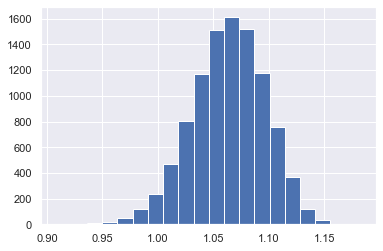

In [16]:
# Long-term stock return distribution: ordinary 2-regime settings
us_eq_sim = r_all_50[:,0,:]

ann_ret_simu = (np.cumprod(1+us_eq_sim,axis=0)[-1,:]) ** (1/50)
plt.hist(ann_ret_simu, bins=20)

### Truncated Distribution
We think that -5% or 15% annualized stock return is not realistic...

So we truncate the return of U.S. stocks such that the 50-year geoetric mean should stay in [4.5%, 8.5%]

In [17]:
asset_retire.n_scenarios = 10000
r_all_cut = asset_retire.regime_simulation_cut(1.045,1.085)
(1+np.mean(np.mean(r_all_cut,axis=0),axis=1))**12

array([1.07621528, 1.06460248, 1.08027367, 1.03441866, 1.05241546,
       1.0399386 , 1.07844666, 1.05244575, 1.02427346])

1.065275538021011 0.011319818838214273


(array([758., 762., 776., 864., 919., 841., 889., 834., 842., 874., 837.,
        804.]),
 array([1.04500331, 1.04833619, 1.05166907, 1.05500195, 1.05833484,
        1.06166772, 1.0650006 , 1.06833348, 1.07166636, 1.07499924,
        1.07833212, 1.081665  , 1.08499788]),
 <a list of 12 Patch objects>)

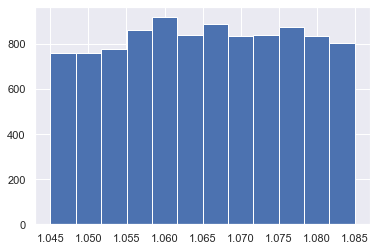

In [18]:
# Long-term stock return distribution: truncated values

us_eq_cut = r_all_cut[:,0,:]
ann_ret_cut = (np.cumprod(1+us_eq_cut,axis=0)[-1,:]) ** (1/50)
print(ann_ret_cut.mean(),ann_ret_cut.std())
plt.hist(ann_ret_cut, bins=12)

## 3. Person Simulation

Note: We simulate macroeconomic variables for retirement planning, since the goal depends on the person's pre-retirement salary, and the interest rate (for discounting).

You may follow the cells below to create macro-based goals, or you can just set some number (e.g. if a female has initial salary of \\$132900 at age 25 that grows with inflation, she need approximately $4 million to replace 80% of her income, with the help of Social Security.

In [19]:
class Person:
    """Defines a person (group) for agent-based simulation of the Social Security fund
    variables:
        age: current age
        retire: retirement age, should not exceed 72
        full_retire: Full Retirement Age (FRA), the age at which 100% benefit is guaranteed
        sex: 'M' or 'F'
    methods:
        total_cont: computes total (discounted) contribution of the person
        
    """
    def __init__(self, age, retire, full_retire, sex):
        self.age = age
        self.retire = min(retire, 72)
        self.full_retire = full_retire
        self.sex = sex
        
    def total_cont(self, tax, benefit, life_table, inf_cum, ir_cum, cola_cum, n_people, death_reduce):
        """
        Simulates total contribution of a group of n_people.
        Length of inf_cum and ir_cum should be 100.
        death_reduce is estimated reduce in death rate.
        """    
        age = self.age
        retire = self.retire
        years_togo = retire - age
        yearly_contribution = np.zeros(len(inf_cum)) # no more than 100
        people_alive = n_people
        survivor_benefit = np.zeros(100) # a vector of people in the benefit, starting from retirement age
        # Early penalty / Late benefit
        if retire >= self.full_retire:
            benefit = benefit * (1+0.08*(retire-self.full_retire))
        else:
            benefit = benefit * (1-0.066*(retire-self.full_retire))
        
        if self.sex == 'M':
            for i in range(years_togo):
                people_died = int(people_alive * life_table['Probability_M'][int(age+i)] * ((1-death_reduce)**i))
                people_alive = people_alive - people_died
                yearly_contribution[i] = people_alive * tax * inf_cum[i]
                
                if i>=10: # Have survivor benefit
                    survivor_benefit[:15] = survivor_benefit[:15] + people_died * .75
                
                if i==years_togo-1: # Test purpose
                    a = yearly_contribution[i]

            for i in range(retire,120):
                people_died = int(people_alive * life_table['Probability_M'][int(i)] * ((1-death_reduce)**(i-age))) 
                people_alive = people_alive - people_died
                # Survivor benefit
                l = int(i-retire)
                u = int(i+max(4, 99-i)/2-retire)   # At least 1 year, but at most 15 years
                survivor_benefit[l:u] = survivor_benefit[l:u] + people_died * .75
                
                yearly_contribution[i-age] = (0-people_alive-survivor_benefit[l]) * benefit * cola_cum[i-age]
                #print(people_alive)
                #print(survivor_benefit)
                if i==retire:
                    b = -yearly_contribution[i-age]

        else:
            for i in range(years_togo):
                people_died = int(people_alive * life_table['Probability_F'][int(age+i)] * ((1-death_reduce)**i))
                people_alive = people_alive - people_died
                yearly_contribution[i] = people_alive * tax * inf_cum[i]
                
                if i>=10: # Have survivor benefit
                    survivor_benefit[:15] = survivor_benefit[:15] + people_died / 3
                
                if i==years_togo-1: # Test purpose
                    a = yearly_contribution[i]

            for i in range(retire,120):
                people_died = int(people_alive * life_table['Probability_F'][int(i)] * ((1-death_reduce)**(i-age))) 
                people_alive = people_alive - people_died
                # Survivor benefit
                l = int(i-retire)
                u = int(i+max(4, 99-i)/2-retire)   # At least 1 year, but at most 15 years
                survivor_benefit[l:u] = survivor_benefit[l:u] + people_died / 3
                
                yearly_contribution[i-age] = (0-people_alive-survivor_benefit[l]) * benefit * cola_cum[i-age]
                
                if i==retire:
                    b = -yearly_contribution[i-age]
        
        #print(people_alive)
        return yearly_contribution / ir_cum

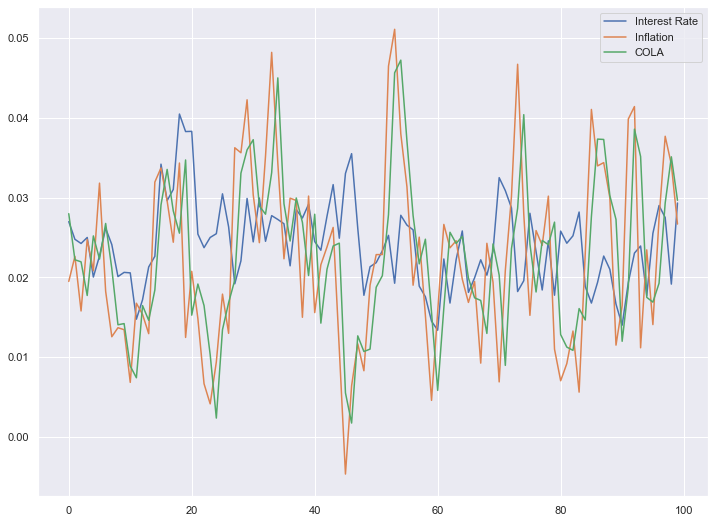

In [20]:
# Mean-reverting
n_years = 100
interest_vec = np.ones(n_years) * 1.027
inflation_vec = np.ones(n_years) * 1.0195
COLA_vec = np.ones(n_years) * 1.028

mu_int = 1.024
mu_inf = 1.022 # theta and sigma adjusted in codes below

np.random.seed(888) # Test = 888, good indicator

for i in range(n_years-1):
    interest_vec[i+1] = interest_vec[i] + 0.5*(mu_int-interest_vec[i]) + 0.004*np.sqrt(interest_vec[i])*randn(1)
    if interest_vec[i+1]<=0: # No negative rate
        interest_vec[i+1] = 0
    inflation_vec[i+1] = inflation_vec[i] + 0.5*(mu_inf-inflation_vec[i]) + 0.01*randn(1)
    COLA_vec[i+1] = 0.1*inflation_vec[i+1] + 0.8*inflation_vec[i] + 0.1*interest_vec[i] + 0.002*randn(1)
    if COLA_vec[i+1]<=0:
        COLA_vec[i] = 0
        
plt.figure(figsize=(12,9))
plt.plot(interest_vec-1,label='Interest Rate')
plt.plot(inflation_vec-1, label='Inflation')
plt.plot(COLA_vec-1,label='COLA')
plt.legend(loc='best')

In [21]:
# Macro variables
n_simulation = 10000
inf_mat = np.zeros((n_simulation, n_years))
ir_mat = np.zeros((n_simulation, n_years))
COLA_mat = np.zeros((n_simulation, n_years))
TIPS_mat = np.zeros((n_simulation, n_years))

mu_int = 1.024
mu_inf = 1.022 # theta and sigma adjusted in codes below

for j in range(n_simulation):
    np.random.seed(j)
    interest_vec = np.ones(n_years) * 1.027
    inflation_vec = np.ones(n_years) * 1.0195
    COLA_vec = np.ones(n_years) * 1.028
    for i in range(n_years-1):
        interest_vec[i+1] = interest_vec[i] + 0.5*(mu_int-interest_vec[i]) + 0.004*np.sqrt(interest_vec[i])*randn(1)
        if interest_vec[i+1]<=0: # No negative rate
            interest_vec[i+1] = 0
        inflation_vec[i+1] = inflation_vec[i] + 0.5*(mu_inf-inflation_vec[i]) + 0.01*randn(1)
        COLA_vec[i+1] = 0.1*inflation_vec[i+1] + 0.8*inflation_vec[i] + 0.1*interest_vec[i] + 0.002*randn(1)
        if COLA_vec[i+1]<=0:
            COLA_vec[i] = 0
    TIPS_vec = inflation_vec + 0.5/100
    inf_mat[j,:] = np.cumprod(inflation_vec)
    ir_mat[j,:] = np.cumprod(interest_vec)
    COLA_mat[j,:] = np.cumprod(COLA_vec)
    TIPS_mat[j,:] = np.cumprod(TIPS_vec)

In [22]:
class PersonalRetirement(Person):
    """
    Simulates the SS and 401(k) accounts for a person.
    
    Variables (Person):
        age: current age
        retire: retirement age, should not exceed 72
        full_retire: Full Retirement Age (FRA), the age at which 100% benefit is guaranteed
        sex: 'M' or 'F'
        init_wage: initial wage (in million dollars)
        
    Variables (Retirement):
        salary_proportion: The goal in terms of proportions
        savings: list of possible savings
        strategy_vec: currently available strategies...
        wealth_list: list of results for each strategy: len(strategy_vec) of "n_scenarios * len(savings)" arrays
        n_scenarios: number of scenarios
        survive_prob: survival probability, starting from retirement age
        wealth_needed: Goal in each
        
    Methods:
        wealth_comp: Compute wealth needed in each scenario
        risk_report: Outputs wealth needed, probability of reaching goal, GaR, CGaR
    """

    def __init__(self, age, retire, full_retire, sex, init_wage, goal, n_scenarios, life_table):
        self.salary_proportion = goal
        self.init_wage = init_wage / 1e6
        self.strategy_vec = []
        self.wealth_list = []
        self.n_scenarios = n_scenarios
        Person.__init__(self, age, retire, full_retire, sex)
        
        life_table_adj = life_table['Probability_'+sex].copy()
        self.survive_prob = np.ones(120-int(retire))
        death_reduce = .65/100 if sex=='M' else .85/100
        
        for i in range(int(retire),119):
            life_table_adj[i] = life_table_adj[i] * ((1-death_reduce)**(i-25))
            self.survive_prob[i-int(retire)+1] = self.survive_prob[i-int(retire)]* (1-life_table_adj[i])
            
        self.savings = ['8%','9%','10%','11%','12%','13%','14%','15%']

    
    def wealth_comp(self, ir_mat, inf_mat, COLA_mat, test_pay=34332):
        """
        test_pay: current maximum benefit amount
        """
        total_required = np.zeros(self.n_scenarios)
        ir_init = int(self.retire-self.age)
        for i in range(self.n_scenarios):
            ir_deflator = ir_mat[i, ir_init:95] / ir_mat[i, ir_init]
            sum_needed = np.sum(self.init_wage * self.survive_prob * inf_mat[i, ir_init:95] * 
                                self.salary_proportion / ir_deflator)
            if self.init_wage >= 0.1329:
                sum_ss = np.sum(test_pay/1e6 * self.survive_prob * COLA_mat[i, ir_init:95] / ir_deflator)
            else:
                test_pay = test_pay * self.init_wage / 132900
                sum_ss = np.sum(test_pay * self.survive_prob * COLA_mat[i, ir_init:95] / ir_deflator)
            total_required[i] = sum_needed - sum_ss
        self.wealth_needed = total_required
    
    def prob_calc(self):
        if self.strategy_vec == []:
            return 0
        index_list = []
        prob_matrix = np.zeros((len(self.strategy_vec),len(self.savings)))
        for i, name in enumerate(self.strategy_vec):
            index_list.append(name+', '+str(self.salary_proportion*100)+'%')
            for j in range(len(self.savings)):
                prob_matrix[i,j] = np.sum(self.wealth_list[i][:,j] > self.wealth_needed) / self.n_scenarios
            
        results_pd = pd.DataFrame(prob_matrix, columns=self.savings, index=index_list)
        return results_pd
    
    def risk_report(self):
        if self.strategy_vec == []:
            return 0
        report_list = np.zeros((4,1))
        for l in self.wealth_list:
            temp_amount = np.sort(self.wealth_needed-l[:,int(self.retire-self.age-1)])
            cut_off = int(self.n_scenarios * threshold - 1)
            temp_arr = np.array([np.median(l[:,int(self.retire-self.age-1)]),
                                 np.mean(temp_amount<0), temp_amount[-cut_off], np.mean(temp_amount[-cut_off:])])
            report_list = np.hstack((report_list, temp_arr.reshape(4,1)))
        return risk_report

In [24]:
def personal_retire_simulation(person, initial_amount, savings_rate, holdings, asset_return, hold_type='fixed'):
    """Simulates monthly data of a person for a certain number of years.
    
    asset_return should be total return, i.e. 1 plus the percentage return.
    if hold_type is "fixed" (by default), holdings is fixed mix with annual rebalance.
    if hold_type is a number, this is fixed mix with rebalance frequency (in months) .
    if hold_type is "SGP", a Bogle rule will be implemented.
    if hold_type is "dynamic", dynamic portfolio optimization will be conducted (to be implemented...)
    
    Other data required:
        inf_mat, ir_mat, COLA_mat: the macro variables simulated
        

    The simulation returns a full path of wealth at the end of each year, so it is a n_scenarios*n_years matrix.
    """
    n_months, n_assets, n_scenarios = asset_return.shape
    wealth_path = np.zeros((n_scenarios, int(n_months/12)))
    
    savings = savings_rate * person.init_wage

    if hold_type == 'fixed':
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
        return wealth_path

    elif type(hold_type)==int:
        ## Needs fix, perhaps not useful at all......
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%hold_type == 0: # Rebalance
                    asset_temp = np.sum(holdings_each)
                    holdings_each = asset_temp * holdings
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path

    elif hold_type == 'SGP':
        ## Gliding path: 90% equity at the beginning, and 46% of equity at the end
        ## Equity: assets 0, 1, 2, 6, 7; Bonds: assets 3, 4, 5, 8.
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                    holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    #if i == 7777: 
                    #Test:print([sum(holdings_each), holdings_each[0]])                    
        return wealth_path        

    elif hold_type == 'RGP':
        ## Gliding path: 36% equity at the beginning, and 80% of equity at the end
        ## Equity: assets 0, 1, 4; Bonds: assets 2, 3, 6, 7.
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (36 + (j+1)/12) / 36
                    holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (64 - (j+1)/12) / 64
                    #if i == 7777: 
                    #Test:print([sum(holdings_each), holdings_each[0]])                    
        return wealth_path 
    
    elif hold_type == 'Dynamic-GP':
        ## Gliding path, same as SGP but tries to catch up when falling behind
        ## Need another vector: standard path
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = 0.0
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth
                
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] >= wealth_vec[int(j/12)+1]:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    else:
                        equity_prop = min((90 - (j+1)/12) + 20, 95)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        n_flag = n_flag + 1
        return n_flag/n_scenarios, wealth_path
    
    elif hold_type == 'Safe-play':
        ## Gliding path, same as SGP but switches to bonds when safe
        ## Need another vector: safe vector
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = 0.0
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
                
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings

                    if wealth_path[i,int(j/12)] <= safe_vec[int(j/12)+1]:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    else:
                        equity_prop = max((90 - (j+1)/12) - 50, 5)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        n_flag = n_flag + 1
        return n_flag/n_scenarios, wealth_path
    
    elif hold_type == 'Zone':
        ## Similar to the idea of 'No-Trade Zone', we have "No-change Zone"
        ## Need other vectors: standard path (wealth_vec) and safe play (safe_vec)
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
            
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        equity_prop = min((90 - (j+1)/12) + 20, 95)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        equity_prop = max((90 - (j+1)/12) - 50, 5)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10 
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
        return n_flag, wealth_path
 
    elif hold_type == 'ZoneSave':
        ## We save more (thus rebalancing the portfolio) when trailing
        ## Need other vectors: standard path (wealth_vec) and safe play (safe_vec)
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
            
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                                      
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        wealth_path[i,int(j/12)] = wealth_path[i,int(j/12)] + 0.03*savings/savings_rate*inf_mat[i,int(j/12)]
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        equity_prop = min((90 - (j+1)/12) + 15, 95)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        equity_prop = max((90 - (j+1)/12) - 50, 5)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10 
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
        #print(safe_vec)
        #print(wealth_vec)
        return n_flag, wealth_path
    
    else:
        ## Buy and Hold...
        for i in range(n_scenarios):
            value =  initial_amount
            for j in range(n_months):
                value = value * np.sum(holdings * asset_return[j,:,i])
                if (j+1)%12==0:
                    value  = value + savings * inf_mat[i,int(j/12)]
                    wealth_path[i,int(j/12)] = value
        return wealth_path

## 4. Retirement Simulation

In [3]:
def simulation_savings(filename,hold_vec,R,retire_age=69, FRA=69, saving_rate = 0.12, init_salary = 132900, n_simulation = 10000):
    """
    R: total return vector
    """
    title = 'save '+str(saving_rate*100)+'%'
    strats=['60-40','Bonds','Target Date','Dynamic-CatchUp','Dynamic-Safe','Dynamic-Zone','Dynamic-ZoneSave']
    report = pd.DataFrame()
    h = int(n_simulation * 0.05-1)
    list_simulation = []
    
    list_people = []
    for i in [0.6,0.7,0.8,0.9]: 
        list_people.append(PersonalRetirement(25, retire_age, FRA, 'F', init_salary, i, n_simulation, life_table))     

    for P in list_people:
        P.wealth_comp(ir_mat, inf_mat, COLA_mat)
        results_1 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[1,:], R[:,:,:n_simulation], 'fixed') 
        results_2 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[0,:], R[:,:,:n_simulation], 'fixed') 
        results_3 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'SGP')
        n_flag5,results_5 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Dynamic-GP')
        n_flag6,results_6 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Safe-play')
        n_flag7,results_7 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Zone') 
        n_flag8,results_8 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'ZoneSave')

        simu_list = [results_1,results_2,results_3,results_5,results_6,results_7,results_8]
        
        report_list = pd.DataFrame(columns=strats, index=['Median Wealth', 'Probability', 'Goal-at-Risk', 
                                               'Conditional Goal-at-Risk', '% Falling Behind', '%Safe',' '])
        for j, r in enumerate(simu_list):
            temp_amount = np.sort(P.wealth_needed-r[:,43])
            temp_arr = np.array([np.median(r[:,43]),np.mean(temp_amount<0), temp_amount[-h], np.mean(temp_amount[-h:])])          
            report_list.iloc[:4,j] = temp_arr
        
        report_list.iloc[4,[3,5,6]] = [n_flag5/50,n_flag7[0]/50,n_flag8[0]/50]
        report_list.iloc[5,[4,5,6]] = [n_flag6/50,n_flag7[1]/50,n_flag8[1]/50]
        report_list.fillna('',inplace=True)
        report = report.append(report_list)
        list_simulation.append(simu_list)
    
    report.to_csv(filename)
    return list_people, list_simulation

In [38]:
hold_vec = np.array([[0, 0, 0, 0.3, 0.3, 0.3, 0, 0, 0.1], # Bonds
                    [0.4, 0.1, 0.2, 0.1, 0, 0.1, 0.1, 0, 0], # "60-40" - 80% equities in fact
                     [0.4, 0.1, 0.3, 0.05, 0, 0.05, 0.1, 0, 0]]) # SGP - 90% equity first

list_people, list_simulation = simulation_savings('result0802.csv',hold_vec,r_all_cut+1)